In [607]:
import json

import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [608]:
# Generate simulated data
!uv run src/sim_data_generator_optimized.py simulated_data/parameters.json

{'output_dir': 'simulated_data/', 'output_exp_file': 'simulated_scRNASeq_data.tsv', 'output_prior_file': 'simulated_prior_data.tsv', 'output_ground_truth_file': 'simulated_ground_truth.tsv', 'n_cells': 2500, 'n_genes': 3000, 'n_tfs': 200, 'ground_truth_active_inactive_prob': 0.2, 'min_num_of_targets_per_tf': 50, 'max_num_of_targets_per_tf': 200, 'tf_effect_factor': 1.25, 'missing_percentage': 40, 'random_seed': 40, 'distribution_type': 'negative_binomial'}
Generating prior data...
Generating gene expression data...
Wrote prior to simulated_prior_data.tsv
Wrote ground truth to simulated_ground_truth.tsv
Wrote gene expression to simulated_scRNASeq_data.tsv


Cells, Genes:(2500, 3000) and 1% Cells: 25
Wrote simulated_data/simulated_scRNASeq_data_stats.tsv


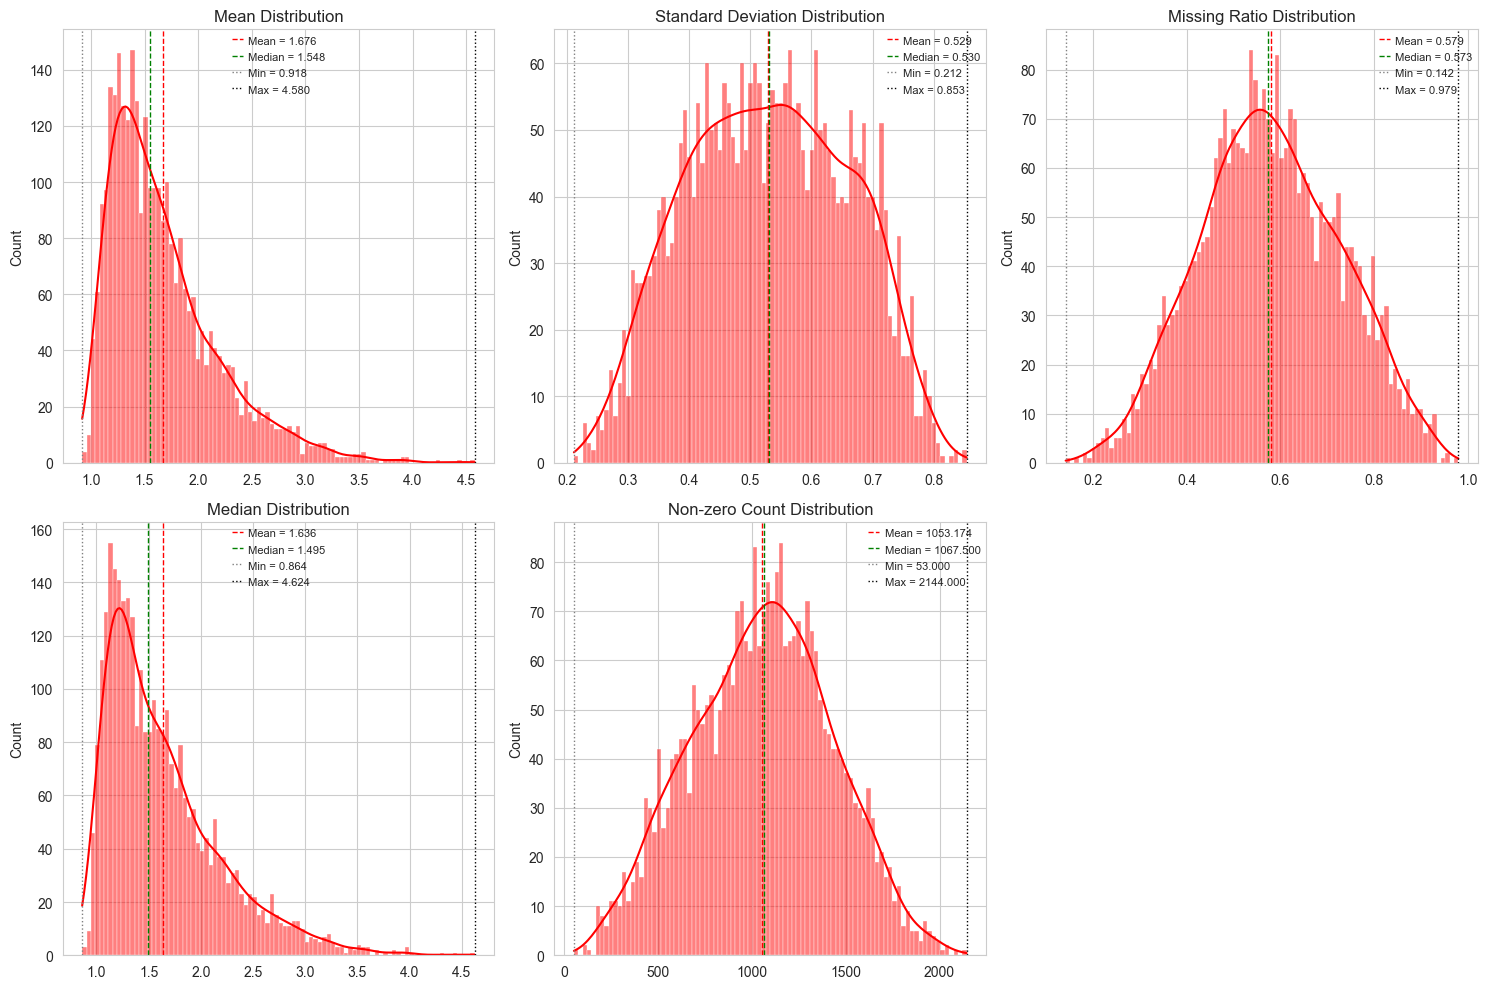

In [609]:
# Plot stats of data
def plot_hist_with_stats(data, ax, title, bins=90, color='red'):
    sns.histplot(data, bins=bins, ax=ax, color=color, kde=True)
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('Count')

    mean_val = np.mean(data)
    median_val = np.median(data)
    min_val = np.min(data)
    max_val = np.max(data)

    # Draw vertical lines
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean = {mean_val:.3f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=1, label=f'Median = {median_val:.3f}')
    ax.axvline(min_val, color='gray', linestyle=':', linewidth=1, label=f'Min = {min_val:.3f}')
    ax.axvline(max_val, color='black', linestyle=':', linewidth=1, label=f'Max = {max_val:.3f}')

    ax.legend(fontsize=8)

# Calculate stats
!uv run src/calculate_stat.py simulated_data/simulated_scRNASeq_data.tsv simulated_data/simulated_scRNASeq_data_stats.tsv


stat_file = "simulated_data/simulated_scRNASeq_data_stats.tsv"
stat_df = pd.read_csv(stat_file, sep="\t", index_col=0)

# Some genes have all zero values. So the plot looks weird.
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

plot_hist_with_stats(stat_df['mean_log'], axs[0, 0], 'Mean Distribution')
plot_hist_with_stats(stat_df['std_log'], axs[0, 1], 'Standard Deviation Distribution')
plot_hist_with_stats(stat_df['missing_ratio'], axs[0, 2], 'Missing Ratio Distribution')
plot_hist_with_stats(stat_df['median_log'], axs[1, 0], 'Median Distribution')
plot_hist_with_stats(stat_df['n_nonzero'], axs[1, 1], 'Non-zero Count Distribution')

# Remove the last empty subplot
fig.delaxes(axs[1, 2])

plt.tight_layout()
plt.show()

In [610]:
# Run kale
!uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores.tsv --ignore_zeros True --cores 8 --method rank_of_ranks

Not Weighted method selected; converting all weights to 1 or -1.
Using raw gene expression as input for per-cell ranking...
-> Using UNWEIGHTED mean rank calculation.
Starting TF activity using 8 cores.
Running in parallel with CORES_USED=8.
Processing cells in parallel: 100%|████████| 2500/2500 [00:03<00:00, 796.76it/s]
[Parallel(n_jobs=8)]: Done 2360 out of 2500 | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 2500 out of 2500 | elapsed:    3.9s finished

Aggregating results...
kale completed


In [611]:
# Gene Expression data
gene_exp_file = "simulated_data/simulated_scRNASeq_data.tsv"

gene_exp = pd.read_csv(gene_exp_file, sep="\t", index_col=0)
adata = sc.AnnData(gene_exp)
adata

AnnData object with n_obs × n_vars = 2500 × 3000

In [612]:
# Prior Knowledge Network
net_file = "simulated_data/simulated_prior_data.tsv"

effect_map = {"upregulates-expression": 1, "downregulates-expression": -1}

net = pd.read_csv(
    net_file,
    sep="\t",
    names=["source", "weight", "target"],
    usecols=[0, 1, 2],
    converters={"weight": effect_map.get}
)[["source", "target", "weight"]]

net.head()

,source,target,weight
0,TF_1,G_2908,1
1,TF_1,G_2129,1
2,TF_1,G_811,1
3,TF_1,G_1894,1
4,TF_1,G_2601,1


### Plot stats of prior knowledge network

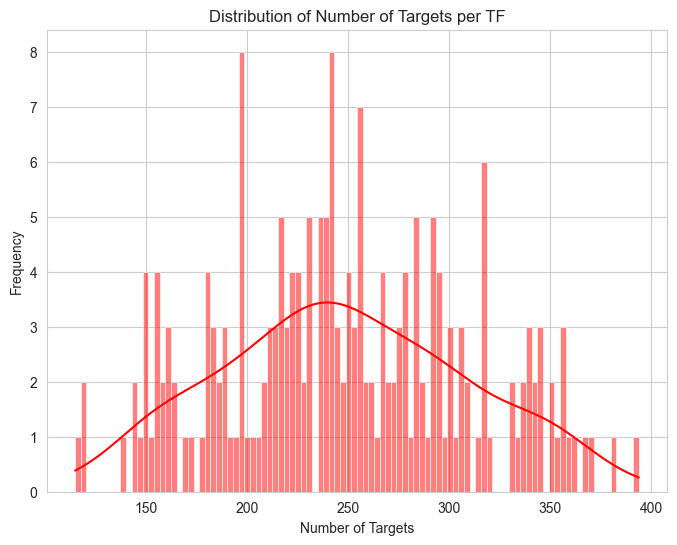

In [613]:
# group the net by source and count the number of targets
net_grouped = net.groupby("source").size().reset_index(name="num_targets")
# Plot histogram of num_targets
plt.figure(figsize=(8, 6))
sns.histplot(net_grouped["num_targets"], bins=100, kde=True, color='red')
plt.title("Distribution of Number of Targets per TF")
plt.xlabel("Number of Targets")
plt.ylabel("Frequency")
plt.show()

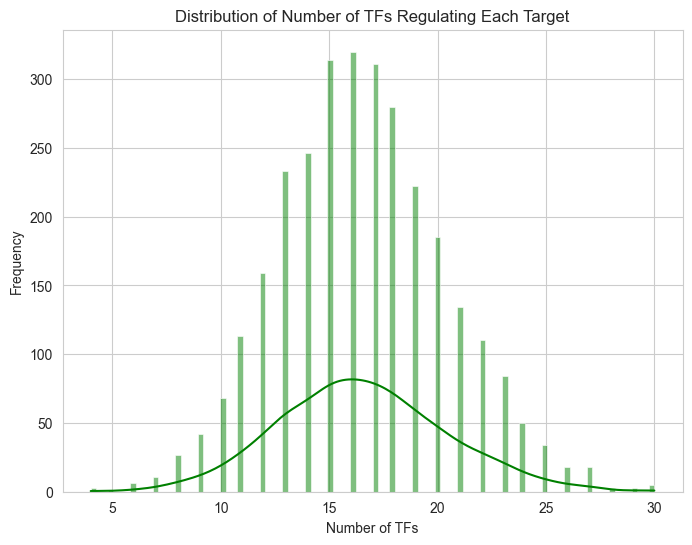

In [614]:
# Count for each target, how many TFs regulate it
target_grouped = net.groupby("target").size().reset_index(name="num_tfs")
target_grouped = target_grouped[target_grouped["num_tfs"] > 1]

# Plot histogram of num_tfs
plt.figure(figsize=(8, 6))
sns.histplot(target_grouped["num_tfs"], bins=100, kde=True, color='green')
plt.title("Distribution of Number of TFs Regulating Each Target")
plt.xlabel("Number of TFs")
plt.ylabel("Frequency")
plt.show()

In [615]:
# Calculate the overalap between top 5 TFs with most targets i.e each first 5 TFs to each other
top_tfs = net_grouped.sort_values(by="num_targets", ascending=False).head(5)
overlaps = []
for i in range(len(top_tfs)):
    for j in range(i + 1, len(top_tfs)):
        tf1 = top_tfs.iloc[i]
        tf2 = top_tfs.iloc[j]
        targets_tf1 = set(net[net["source"] == tf1["source"]]["target"])
        targets_tf2 = set(net[net["source"] == tf2["source"]]["target"])
        overlap = targets_tf1.intersection(targets_tf2)
        print(f"{tf1['source']}: {tf1['num_targets']} targets, \t {tf2['source']}: {tf2['num_targets']} targets.")
        print(f"\t No. of overlapping targets: {len(overlap)} ...............")
        overlaps.append(len(overlap))

print("-----")
print("Average overlap among top 5 TFs:", np.mean(overlaps))

TF_66: 394 targets, 	 TF_145: 382 targets.
	 No. of overlapping targets: 50 ...............
TF_66: 394 targets, 	 TF_158: 369 targets.
	 No. of overlapping targets: 45 ...............
TF_66: 394 targets, 	 TF_106: 367 targets.
	 No. of overlapping targets: 49 ...............
TF_66: 394 targets, 	 TF_167: 362 targets.
	 No. of overlapping targets: 52 ...............
TF_145: 382 targets, 	 TF_158: 369 targets.
	 No. of overlapping targets: 53 ...............
TF_145: 382 targets, 	 TF_106: 367 targets.
	 No. of overlapping targets: 46 ...............
TF_145: 382 targets, 	 TF_167: 362 targets.
	 No. of overlapping targets: 36 ...............
TF_158: 369 targets, 	 TF_106: 367 targets.
	 No. of overlapping targets: 47 ...............
TF_158: 369 targets, 	 TF_167: 362 targets.
	 No. of overlapping targets: 53 ...............
TF_106: 367 targets, 	 TF_167: 362 targets.
	 No. of overlapping targets: 49 ...............
-----
Average overlap among top 5 TFs: 48.0


In [616]:
# # Prior Knowledge Network
# net_file = "data/causal_priors.tsv"
#
# effect_map = {"upregulates-expression": 1, "downregulates-expression": -1}
#
# net = pd.read_csv(
#     net_file,
#     sep="\t",
#     names=["source", "weight", "target"],
#     usecols=[0, 1, 2],
#     converters={"weight": effect_map.get}
# )[["source", "target", "weight"]]
#
# net.head()
#
# # group the net by source and count number of targets
# net_grouped = net.groupby("source").size().reset_index(name="num_targets")
# # Plot histogram of num_targets
# plt.figure(figsize=(8, 6))
# sns.histplot(net_grouped["num_targets"], bins=100, kde=True, color='red')
# plt.title("Distribution of Number of Targets per TF")
# plt.xlabel("Number of Targets")
# plt.ylabel("Frequency")
# plt.show()

### Ground Truths and ROC Curve

In [617]:
# Ground Truths
ground_truths_file = "simulated_data/simulated_ground_truth.tsv"

ground_truths = pd.read_csv(ground_truths_file, sep="\t", index_col=0)
ground_truths = ground_truths.reset_index().rename(columns={"index": "Cell"})
ground_truths = pd.melt(ground_truths, id_vars=["Cell"], var_name="TF", value_name="Value")
ground_truths["Cell_TF"] = ground_truths["Cell"] + "_" + ground_truths["TF"]
ground_truths = ground_truths[["Cell_TF", "Value"]]

print(f"Ground truths shape: {ground_truths.shape}")
print(ground_truths.head(10))

Ground truths shape: (500000, 2)
        Cell_TF  Value
0   Cell_1_TF_1      0
1   Cell_2_TF_1     -1
2   Cell_3_TF_1     -1
3   Cell_4_TF_1      0
4   Cell_5_TF_1      1
5   Cell_6_TF_1      1
6   Cell_7_TF_1      0
7   Cell_8_TF_1      0
8   Cell_9_TF_1     -1
9  Cell_10_TF_1     -1


In [618]:
methods_to_run = ["viper", "mlm"]
dc.mt.decouple(adata, net, tmin=1, methods=methods_to_run)

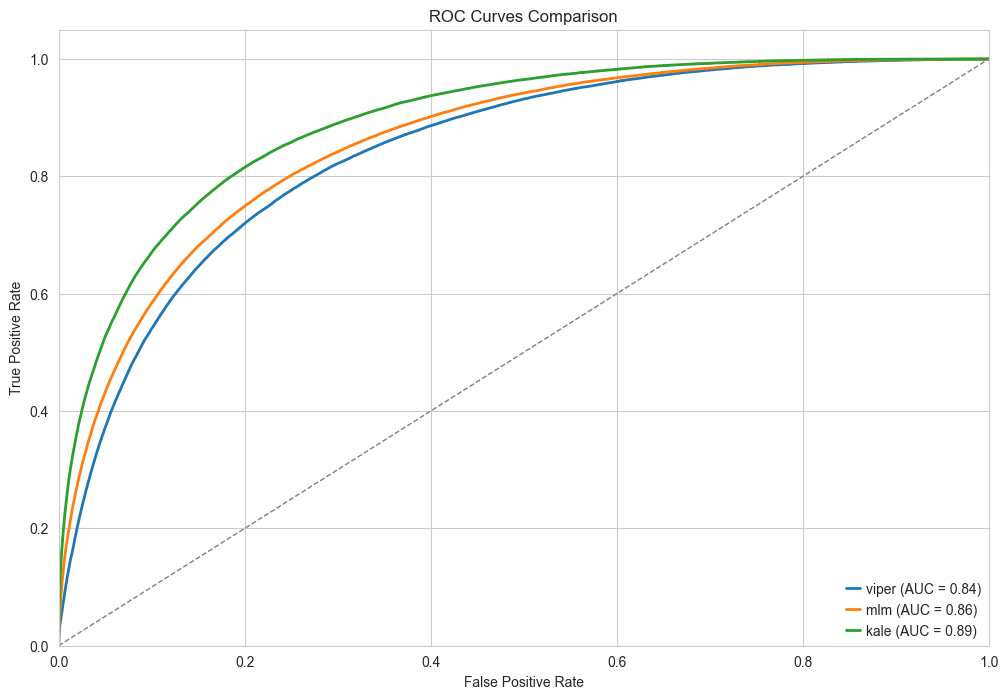

In [619]:
plt.figure(figsize=(12, 8))

methods_to_run.append("kale")

for method in methods_to_run:
    if method == "kale":
        method_scores = pd.read_csv("simulated_data/_kale_scores.tsv", sep="\t", index_col=0)

    else:
        # Get the scores for the current method
        method_scores = adata.obsm[f"score_{method}"]

    # Melt the DataFrame to long format
    scores_out = method_scores.reset_index().rename(columns={"index": "Cell"})
    scores_out = pd.melt(scores_out, id_vars=["Cell"], var_name="TF", value_name="Value")
    scores_out["Cell_TF"] = scores_out["Cell"] + "_" + scores_out["TF"]
    scores_out = scores_out[["Cell_TF", "Value"]]

    # Merge with ground truths
    scores_merged = scores_out.merge(ground_truths, on="Cell_TF", suffixes=("_pred", "_true"))

    # Sort by Cell_TF to ensure consistent ordering
    scores_merged = scores_merged.sort_values(by="Value_pred", ascending=False)
    scores_merged['y_true'] = (scores_merged['Value_true'] == 1.0).astype(int)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(scores_merged['y_true'], scores_merged['Value_pred'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{method} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.show()

In [449]:
End

NameError: name 'Error' is not defined

## parameters.json test suite

In [322]:
final_result = []

test_suite = [
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 5500,
        "n_genes": 3000,
        "n_tfs": 100,
        "ground_truth_active_inactive_prob": 0.1,
        "min_num_of_targets_per_tf": 5,
        "max_num_of_targets_per_tf": 100,
        "tf_effect_factor": 1.5,
        "missing_percentage": 89,
        "random_seed": 42,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 2500,
        "n_genes": 3000,
        "n_tfs": 200,
        "ground_truth_active_inactive_prob": 0.15,
        "min_num_of_targets_per_tf": 10,
        "max_num_of_targets_per_tf": 100,
        "tf_effect_factor": 1.25,
        "missing_percentage": 90,
        "random_seed": 42,
        "distribution_type": "negative_binomial"
    },
    {
        "output_dir": "simulated_data/",
        "output_exp_file": "simulated_scRNASeq_data.tsv",
        "output_prior_file": "simulated_prior_data.tsv",
        "output_ground_truth_file": "simulated_ground_truth.tsv",
        "n_cells": 5000,
        "n_genes": 3000,
        "n_tfs": 300,
        "ground_truth_active_inactive_prob": 0.15,
        "min_num_of_targets_per_tf": 10,
        "max_num_of_targets_per_tf": 100,
        "tf_effect_factor": 1.65,
        "missing_percentage": 85,
        "random_seed": 11,
        "distribution_type": "negative_binomial"
    }
]

for i, test_case in enumerate(test_suite):
    with open("simulated_data/parameters.json", "w") as f:
        json.dump(test_case, f, indent=4)


    # Generate simulated data
    !uv run src/sim_data_generator_optimized.py simulated_data/parameters.json


    # Run kale
    !uv run src/kale.py --gene_exp_file simulated_data/simulated_scRNASeq_data.tsv --prior_file simulated_data/simulated_prior_data.tsv --output_file simulated_data/_kale_scores.tsv --ignore_zeros True --cores 8 --method rank_of_ranks


    # Gene Expression data
    gene_exp_file = "simulated_data/simulated_scRNASeq_data.tsv"
    gene_exp = pd.read_csv(gene_exp_file, sep="\t", index_col=0)
    adata = sc.AnnData(gene_exp)

    # Prior Knowledge Network
    net_file = "simulated_data/simulated_prior_data.tsv"
    effect_map = {"upregulates-expression": 1, "downregulates-expression": -1}
    net = pd.read_csv(
        net_file,
        sep="\t",
        names=["source", "weight", "target"],
        usecols=[0, 1, 2],
        converters={"weight": effect_map.get}
    )[["source", "target", "weight"]]

    # Ground Truths
    ground_truths_file = "simulated_data/simulated_ground_truth.tsv"
    ground_truths = pd.read_csv(ground_truths_file, sep="\t", index_col=0)
    ground_truths = ground_truths.reset_index().rename(columns={"index": "Cell"})
    ground_truths = pd.melt(ground_truths, id_vars=["Cell"], var_name="TF", value_name="Value")
    ground_truths["Cell_TF"] = ground_truths["Cell"] + "_" + ground_truths["TF"]
    ground_truths = ground_truths[["Cell_TF", "Value"]]

    # Run other methods
    methods_to_run = ["viper", "mlm"]
    dc.mt.decouple(adata, net, tmin=1, methods=methods_to_run)

    methods_to_run.append("kale")
    for method in methods_to_run:
        if method == "kale":
            method_scores = pd.read_csv("simulated_data/_kale_scores.tsv", sep="\t", index_col=0)
        else:
            method_scores = adata.obsm[f"score_{method}"]

        # Melt the DataFrame to long format
        scores_out = method_scores.reset_index().rename(columns={"index": "Cell"})
        scores_out = pd.melt(scores_out, id_vars=["Cell"], var_name="TF", value_name="Value")
        scores_out["Cell_TF"] = scores_out["Cell"] + "_" + scores_out["TF"]
        scores_out = scores_out[["Cell_TF", "Value"]]

        # Merge with ground truths
        scores_merged = scores_out.merge(ground_truths, on="Cell_TF", suffixes=("_pred", "_true"))

        # Sort by Cell_TF to ensure consistent ordering
        scores_merged = scores_merged.sort_values(by="Value_pred", ascending=False)
        scores_merged['y_true'] = (scores_merged['Value_true'] == 1.0).astype(int)

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(scores_merged['y_true'], scores_merged['Value_pred'])
        roc_auc = auc(fpr, tpr)

        # collect AUC results
        test_case["auc_" + method] = roc_auc

    final_result.append(test_case)

# Save final results to a CSV file
final_result_df = pd.DataFrame(final_result)
final_result_df.drop(
    ['output_dir', 'output_exp_file', 'output_prior_file', 'output_ground_truth_file', 'distribution_type'], axis=1,
    inplace=True)
# final_result_df.to_csv("simulated_data/simulation_test_suite_results_.csv", index=False)

{'output_dir': 'simulated_data/', 'output_exp_file': 'simulated_scRNASeq_data.tsv', 'output_prior_file': 'simulated_prior_data.tsv', 'output_ground_truth_file': 'simulated_ground_truth.tsv', 'n_cells': 5500, 'n_genes': 3000, 'n_tfs': 100, 'ground_truth_active_inactive_prob': 0.1, 'min_num_of_targets_per_tf': 5, 'max_num_of_targets_per_tf': 100, 'tf_effect_factor': 1.5, 'missing_percentage': 89, 'random_seed': 42, 'distribution_type': 'negative_binomial'}
Generating prior data...
Generating gene expression data...
Zero percentage before dropout: 1.3495151515151516
Zero percentage after dropout: 89.14093939393939
Wrote prior to simulated_prior_data.tsv
Wrote ground truth to simulated_ground_truth.tsv
Wrote gene expression to simulated_scRNASeq_data.tsv
Not Weighted method selected; converting all weights to 1 or -1.
Using raw gene expression as input for per-cell ranking...
-> Using UNWEIGHTED mean rank calculation.
Starting TF activity using 8 cores.
Running in parallel with CORES_USED=

In [ ]:
final_result_df  # Recreating old result

In [323]:
final_result_df  # More missing values, Ignore zeros = False

,n_cells,n_genes,n_tfs,ground_truth_active_inactive_prob,min_num_of_targets_per_tf,max_num_of_targets_per_tf,tf_effect_factor,missing_percentage,random_seed,auc_viper,auc_mlm,auc_kale
0,5500,3000,100,0.10,5,100,1.50,89,42,0.521898,0.560177,0.508681
1,2500,3000,200,0.15,10,100,1.25,90,42,0.515548,0.539993,0.503883
2,5000,3000,300,0.15,10,100,1.65,85,11,0.549205,0.606369,0.519939


In [321]:
final_result_df  # More missing values, Ignore zeros = True

,n_cells,n_genes,n_tfs,ground_truth_active_inactive_prob,min_num_of_targets_per_tf,max_num_of_targets_per_tf,tf_effect_factor,missing_percentage,random_seed,auc_viper,auc_mlm,auc_kale
0,5500,3000,100,0.10,5,100,1.50,89,42,0.521898,0.560177,0.679225
1,2500,3000,200,0.15,10,100,1.25,90,42,0.515548,0.539993,0.630989
2,5000,3000,300,0.15,10,100,1.65,85,11,0.549205,0.606369,0.776215


In [318]:
final_result_df

,n_cells,n_genes,n_tfs,ground_truth_active_inactive_prob,min_num_of_targets_per_tf,max_num_of_targets_per_tf,tf_effect_factor,missing_percentage,random_seed,distribution_type,auc_viper,auc_mlm,auc_kale
0,5500,3000,100,0.10,5,100,1.50,80,42,negative_binomial,0.541629,0.591968,0.743860
1,2500,3000,200,0.15,10,100,1.25,70,42,negative_binomial,0.545126,0.581866,0.727310
2,5000,3000,300,0.15,10,100,1.65,60,11,negative_binomial,0.631812,0.690184,0.894046


In [315]:
final_result_df

,n_cells,n_genes,n_tfs,ground_truth_active_inactive_prob,min_num_of_targets_per_tf,max_num_of_targets_per_tf,tf_effect_factor,missing_percentage,random_seed,distribution_type,auc_viper,auc_mlm,auc_kale
0,5500,3000,100,0.10,5,100,1.50,80,42,negative_binomial,0.541629,0.591968,0.529376
1,2500,3000,200,0.15,10,100,1.25,70,42,negative_binomial,0.545126,0.581866,0.542181
2,5000,3000,300,0.15,10,100,1.65,60,11,negative_binomial,0.631812,0.690184,0.634650


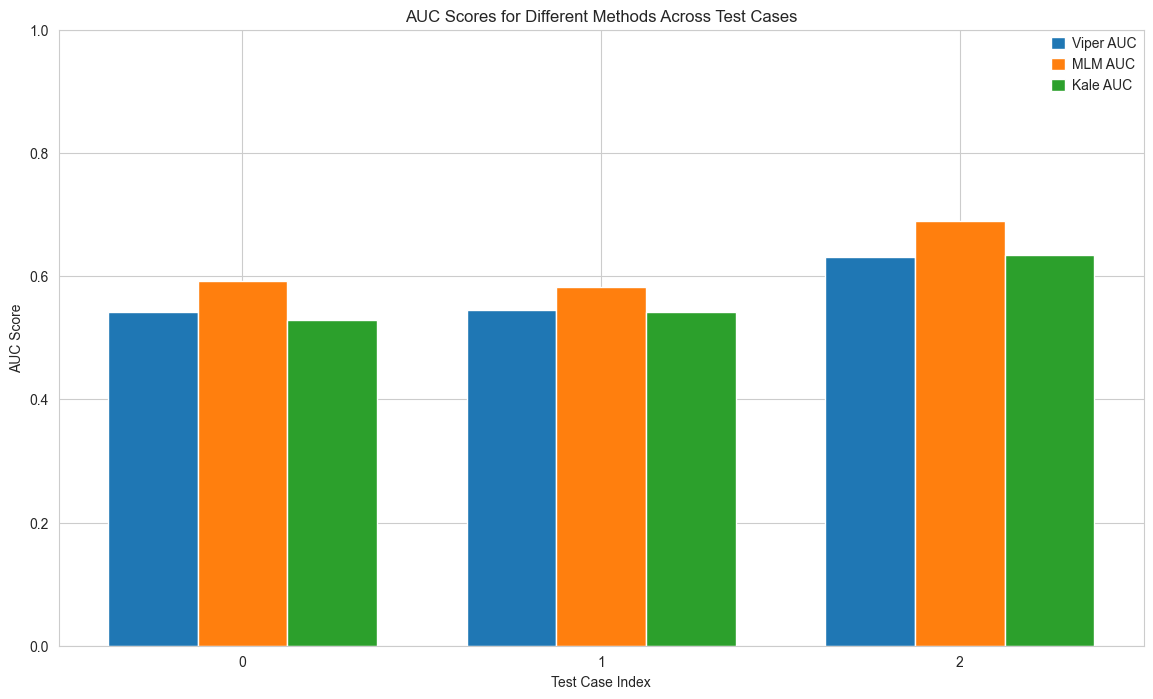

In [316]:
# Plot auc_viper, auc_mlm, auc_kale for each test case
plt.figure(figsize=(14, 8))
x = np.arange(len(final_result_df))
width = 0.25
plt.bar(x - width, final_result_df['auc_viper'], width, label='Viper AUC')
plt.bar(x, final_result_df['auc_mlm'], width, label='MLM AUC')
plt.bar(x + width, final_result_df['auc_kale'], width, label='Kale AUC')
plt.xlabel('Test Case Index')
plt.ylabel('AUC Score')
plt.title('AUC Scores for Different Methods Across Test Cases')
plt.xticks(x)
plt.ylim(0, 1)
plt.legend()
plt.show()


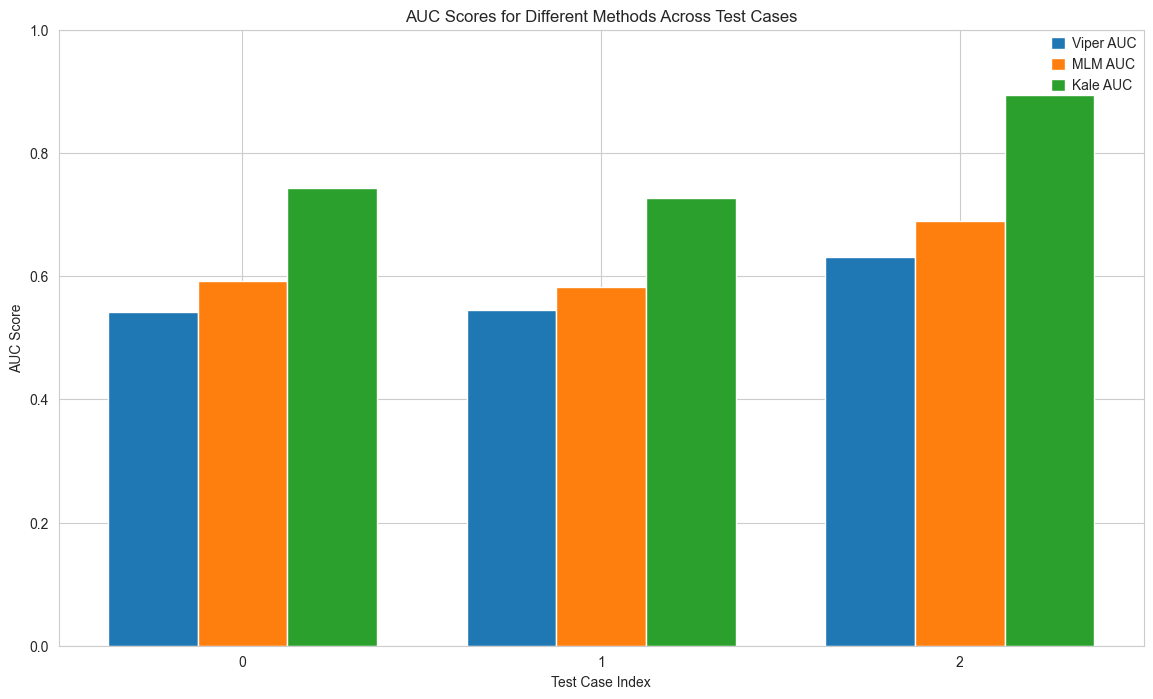

In [319]:
# Plot auc_viper, auc_mlm, auc_kale for each test case
plt.figure(figsize=(14, 8))
x = np.arange(len(final_result_df))
width = 0.25
plt.bar(x - width, final_result_df['auc_viper'], width, label='Viper AUC')
plt.bar(x, final_result_df['auc_mlm'], width, label='MLM AUC')
plt.bar(x + width, final_result_df['auc_kale'], width, label='Kale AUC')
plt.xlabel('Test Case Index')
plt.ylabel('AUC Score')
plt.title('AUC Scores for Different Methods Across Test Cases')
plt.xticks(x)
plt.ylim(0, 1)
plt.legend()
plt.show()

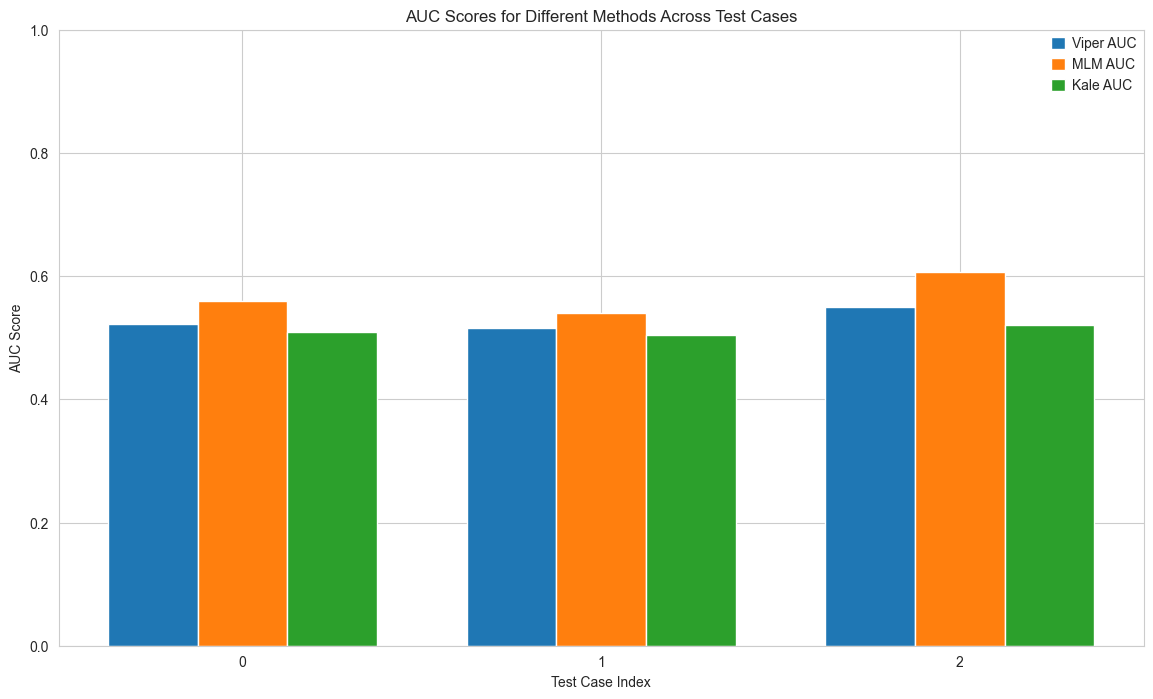

In [324]:
# Plot auc_viper, auc_mlm, auc_kale for each test case
plt.figure(figsize=(14, 8))
x = np.arange(len(final_result_df))
width = 0.25
plt.bar(x - width, final_result_df['auc_viper'], width, label='Viper AUC')
plt.bar(x, final_result_df['auc_mlm'], width, label='MLM AUC')
plt.bar(x + width, final_result_df['auc_kale'], width, label='Kale AUC')
plt.xlabel('Test Case Index')
plt.ylabel('AUC Score')
plt.title('AUC Scores for Different Methods Across Test Cases')
plt.xticks(x)
plt.ylim(0, 1)
plt.legend()
plt.show()